In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import KFold

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
data_path = "../data/data.csv"
data = pd.read_csv(data_path)

# Metadata
movie_metadata = data[['movieId', 'title', 'movie_rating', 'year', 'genres']].drop_duplicates().set_index('movieId')
user_metadata = data[['userId']].drop_duplicates()

# Encoders
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

data['user_encoded'] = user_encoder.fit_transform(data['userId'])
data['movie_encoded'] = movie_encoder.fit_transform(data['movieId'])

n_users = data['user_encoded'].nunique()
n_movies = data['movie_encoded'].nunique()

# Scaling
scaler_movie_rating = StandardScaler()
scaler_year = StandardScaler()

data['movie_rating_scaled'] = scaler_movie_rating.fit_transform(data[['movie_rating']])
data['year_scaled'] = scaler_year.fit_transform(data[['year']])

# Mappings
user_id_to_encoded = dict(zip(data['userId'], data['user_encoded']))
movie_id_to_encoded = dict(zip(data['movieId'], data['movie_encoded']))
encoded_to_user_id = dict(zip(data['user_encoded'], data['userId']))
encoded_to_movie_id = dict(zip(data['movie_encoded'], data['movieId']))


In [3]:
X = {
    'user_id': data['user_encoded'].values,
    'movie_id': data['movie_encoded'].values,
    'movie_rating': data['movie_rating_scaled'].values,
    'year': data['year_scaled'].values
}
y = data['rating'].values

X_temp, X_test, y_temp, y_test = {}, {}, None, None
for key in X:
    X_temp[key], X_test[key] = train_test_split(X[key], test_size=0.2, random_state=42)

y_temp, y_test = train_test_split(y, test_size=0.2, random_state=42)

val_ratio = 0.1 / 0.8
X_train, X_val = {}, {}
for key in X_temp:
    X_train[key], X_val[key] = train_test_split(X_temp[key], test_size=val_ratio, random_state=42)

y_train, y_val = train_test_split(y_temp, test_size=val_ratio, random_state=42)

In [5]:
embedding_dim = 64
hidden_units = [128, 64, 32]
dropout_rate = 0.3
l2_reg = 0.001

user_input = layers.Input(shape=(), name='user_id')
movie_input = layers.Input(shape=(), name='movie_id')
movie_rating_input = layers.Input(shape=(), name='movie_rating')
year_input = layers.Input(shape=(), name='year')

user_embedding = layers.Embedding(n_users, embedding_dim, embeddings_regularizer=keras.regularizers.l2(l2_reg))(user_input)
movie_embedding = layers.Embedding(n_movies, embedding_dim, embeddings_regularizer=keras.regularizers.l2(l2_reg))(movie_input)

user_vec = layers.Flatten()(user_embedding)
movie_vec = layers.Flatten()(movie_embedding)

dot_product = layers.Dot(axes=1)([user_vec, movie_vec])
element_wise = layers.Multiply()([user_vec, movie_vec])

concat = layers.Concatenate()([
    user_vec,
    movie_vec,
    dot_product,
    element_wise,
    layers.Reshape((1,))(movie_rating_input),
    layers.Reshape((1,))(year_input)
])

x = concat
for i, units in enumerate(hidden_units):
    x = layers.Dense(units, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

output = layers.Dense(1, activation='linear')(x)
model = keras.Model(inputs=[user_input, movie_input, movie_rating_input, year_input], outputs=output)


In [6]:
model.compile(optimizer=keras.optimizers.Adam(0.001), loss='mse', metrics=['mae', 'mse'])

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6),
    keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)
]

history = model.fit(
    x=[X_train['user_id'], X_train['movie_id'], X_train['movie_rating'], X_train['year']],
    y=y_train,
    validation_data=(
        [X_val['user_id'], X_val['movie_id'], X_val['movie_rating'], X_val['year']],
        y_val
    ),
    epochs=50,
    batch_size=1024,
    callbacks=callbacks
)


Epoch 1/50


69/69 [==============================] - 5s 28ms/step - loss: 12.9855 - mae: 3.2886 - mse: 12.4399 - val_loss: 11.2510 - val_mae: 3.1229 - val_mse: 10.7803 - lr: 0.0010
Epoch 2/50
 4/69 [>.............................] - ETA: 1s - loss: 10.9423 - mae: 3.0190 - mse: 10.4725

c:\Users\FX506\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 1s 20ms/step - loss: 9.1543 - mae: 2.7036 - mse: 8.7022 - val_loss: 7.5400 - val_mae: 2.4836 - val_mse: 7.1043 - lr: 0.0010
Epoch 3/50
69/69 [==============================] - 2s 23ms/step - loss: 5.3450 - mae: 1.8918 - mse: 4.9222 - val_loss: 3.6292 - val_mae: 1.6079 - val_mse: 3.2197 - lr: 0.0010
Epoch 4/50
69/69 [==============================] - 2s 22ms/step - loss: 3.0861 - mae: 1.2753 - mse: 2.6900 - val_loss: 1.8751 - val_mae: 1.0441 - val_mse: 1.4928 - lr: 0.0010
Epoch 5/50
69/69 [==============================] - 2s 23ms/step - loss: 2.3606 - mae: 1.0564 - mse: 1.9919 - val_loss: 1.4101 - val_mae: 0.8504 - val_mse: 1.0556 - lr: 0.0010
Epoch 6/50
69/69 [==============================] - 1s 20ms/step - loss: 2.0363 - mae: 0.9792 - mse: 1.6955 - val_loss: 1.1573 - val_mae: 0.7379 - val_mse: 0.8305 - lr: 0.0010
Epoch 7/50
69/69 [==============================] - 2s 27ms/step - loss: 1.7920 - mae: 0.9180 - mse: 1.4783 - val_loss: 1.0807 - va

In [7]:
y_pred = model.predict([
    X_test['user_id'], X_test['movie_id'],
    X_test['movie_rating'], X_test['year']
]).flatten()

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
pearson_corr, _ = pearsonr(y_test, y_pred)
spearman_corr, _ = spearmanr(y_test, y_pred)

print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
print(f"Pearson: {pearson_corr:.4f}, Spearman: {spearman_corr:.4f}")


631/631 [==============================] - 1s 2ms/step
RMSE: 0.8075, MAE: 0.6163, R²: 0.4044
Pearson: 0.6389, Spearman: 0.6297


In [8]:
# Siapkan variabel untuk training
X_kfold = X_temp  # 80% data
y_kfold = y_temp
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_histories = []
fold_metrics = []

for fold, (train_idx, val_idx) in enumerate(kf.split(y_kfold)):
    print(f"\n--- Fold {fold + 1} ---")

    # Buat input untuk model (harus list bukan dict)
    X_train = [
        X_kfold['user_id'][train_idx],
        X_kfold['movie_id'][train_idx],
        X_kfold['movie_rating'][train_idx],
        X_kfold['year'][train_idx]
    ]
    X_val = [
        X_kfold['user_id'][val_idx],
        X_kfold['movie_id'][val_idx],
        X_kfold['movie_rating'][val_idx],
        X_kfold['year'][val_idx]
    ]
    y_train = y_kfold[train_idx]
    y_val = y_kfold[val_idx]

    # Model
    user_input = keras.Input(shape=(1,), name='user_id')
    movie_input = keras.Input(shape=(1,), name='movie_id')
    rating_input = keras.Input(shape=(1,), name='movie_rating')
    year_input = keras.Input(shape=(1,), name='year')

    user_embedding = layers.Embedding(n_users, 50)(user_input)
    movie_embedding = layers.Embedding(n_movies, 50)(movie_input)

    user_vec = layers.Flatten()(user_embedding)
    movie_vec = layers.Flatten()(movie_embedding)

    x = layers.Concatenate()([user_vec, movie_vec, rating_input, year_input])
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu')(x)
    output = layers.Dense(1)(x)

    model = keras.Model(inputs=[user_input, movie_input, rating_input, year_input], outputs=output)
    model.compile(optimizer=keras.optimizers.Adam(0.001), loss='mse', metrics=['mae', 'mse'])

    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)
    ]

    history = model.fit(
        x=X_train,
        y=y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=1024,
        callbacks=callbacks,
        verbose=0
    )

    fold_histories.append(history)

    y_pred = model.predict(X_val).flatten()
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    pearson_corr, _ = pearsonr(y_val, y_pred)
    spearman_corr, _ = spearmanr(y_val, y_pred)

    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    print(f"Pearson: {pearson_corr:.4f}, Spearman: {spearman_corr:.4f}")

    fold_metrics.append({
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'pearson': pearson_corr,
        'spearman': spearman_corr
    })



--- Fold 1 ---
505/505 [==============================] - 1s 2ms/step
RMSE: 0.8352, MAE: 0.6403, R²: 0.3601
Pearson: 0.6081, Spearman: 0.6045

--- Fold 2 ---
505/505 [==============================] - 1s 2ms/step
RMSE: 0.8299, MAE: 0.6298, R²: 0.3524
Pearson: 0.6045, Spearman: 0.5994

--- Fold 3 ---
505/505 [==============================] - 1s 1ms/step
RMSE: 0.8312, MAE: 0.6363, R²: 0.3616
Pearson: 0.6077, Spearman: 0.5975

--- Fold 4 ---
505/505 [==============================] - 1s 2ms/step
RMSE: 0.8350, MAE: 0.6386, R²: 0.3704
Pearson: 0.6166, Spearman: 0.6062

--- Fold 5 ---
505/505 [==============================] - 1s 2ms/step
RMSE: 0.8459, MAE: 0.6463, R²: 0.3375
Pearson: 0.5928, Spearman: 0.5884


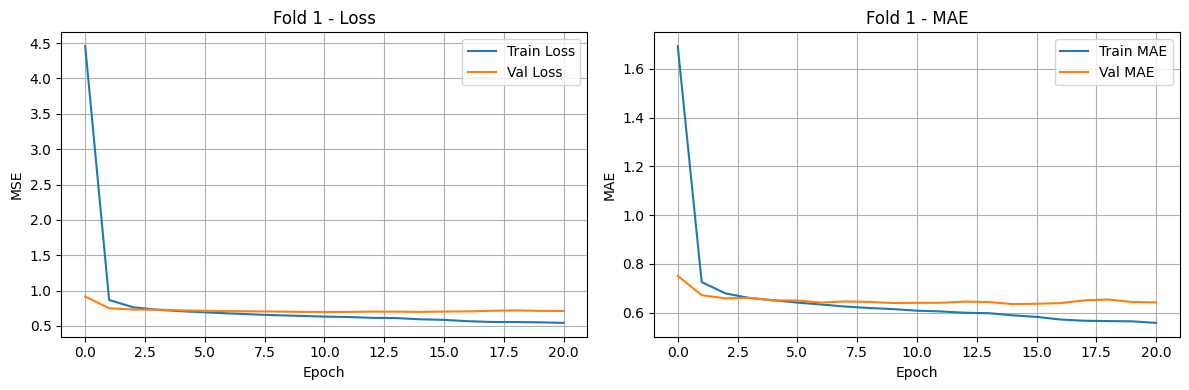

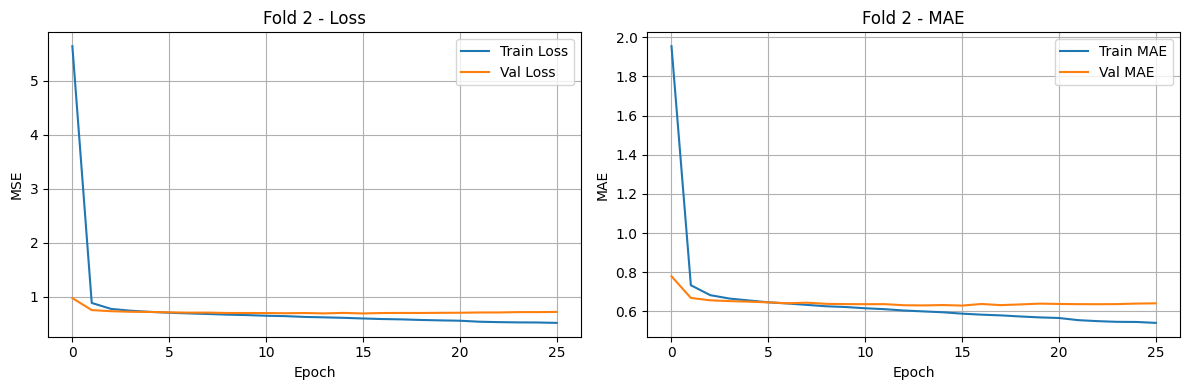

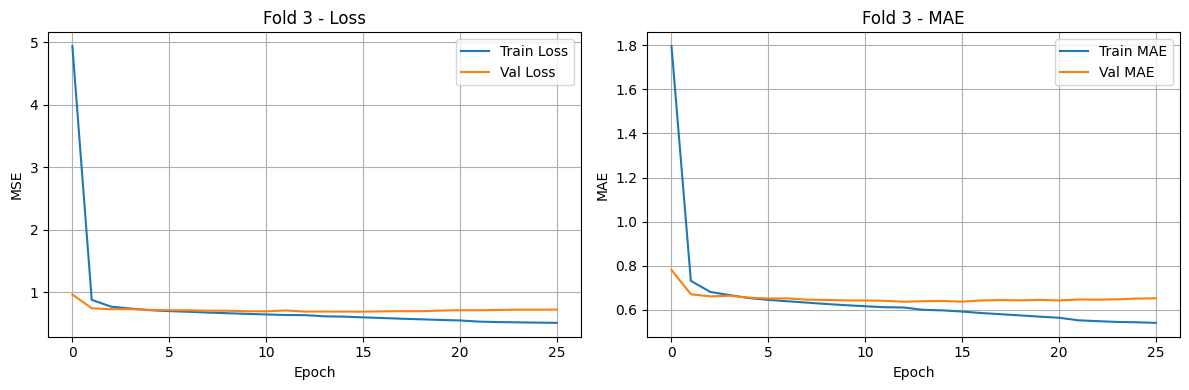

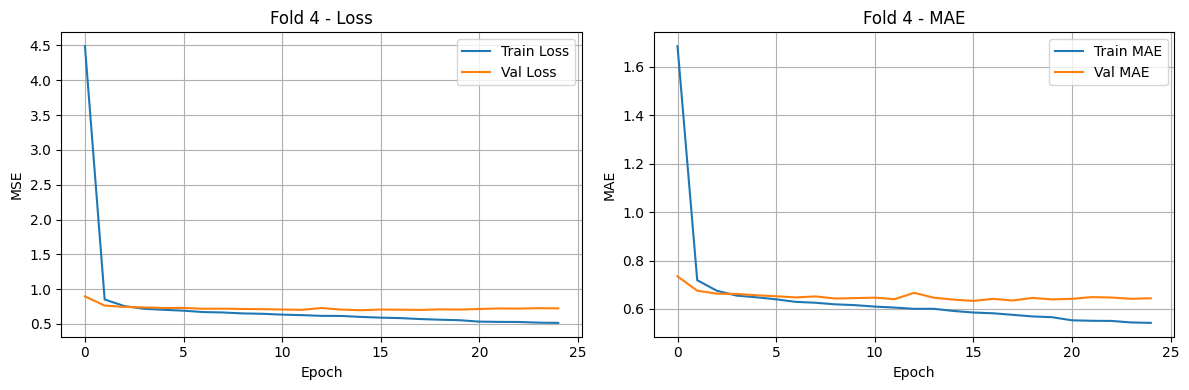

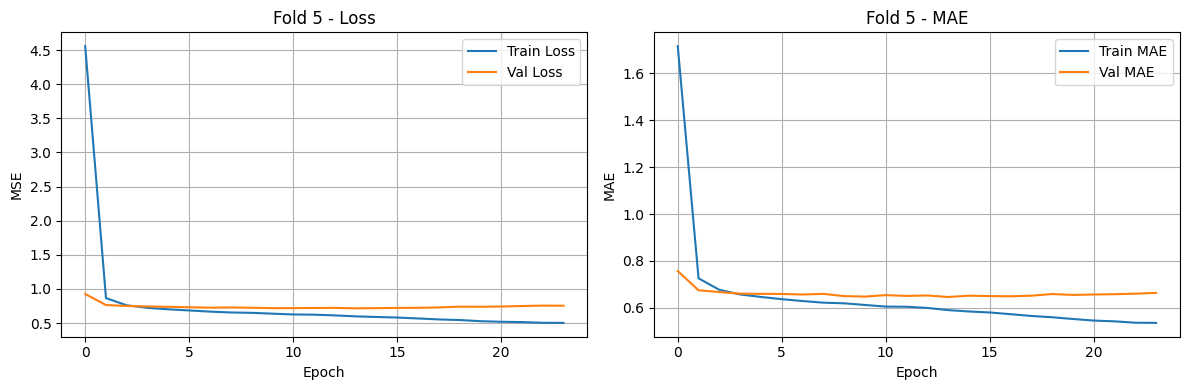

In [9]:
for i, history in enumerate(fold_histories):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {i+1} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title(f'Fold {i+1} - MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [10]:
# Save full model (architecture + weights + optimizer state)
model.save("../models/final_model.keras")


In [11]:
loaded_model = keras.models.load_model("../models/final_model.keras")

In [14]:
# Netflix-style Recommendation Display in Notebook (tanpa def)

# Pilih userId (yang asli)
target_user_id = 1  # Ganti dengan userId valid dari dataset

if target_user_id not in user_id_to_encoded:
    print(f"❌ User ID {target_user_id} tidak ditemukan.")
else:
    user_enc = user_id_to_encoded[target_user_id]
    
    # Ambil semua movieId
    all_movie_ids = movie_metadata.index.tolist()
    user_watched = data[data['userId'] == target_user_id]['movieId'].tolist()
    candidate_movie_ids = [mid for mid in all_movie_ids if mid not in user_watched]

    if not candidate_movie_ids:
        print(f"🎯 User {target_user_id} telah menonton semua film yang tersedia.")
    else:
        movie_encodings = [movie_id_to_encoded[mid] for mid in candidate_movie_ids]
        user_array = np.array([user_enc] * len(candidate_movie_ids))
        movie_array = np.array(movie_encodings)

        movie_ratings = np.array([
            movie_metadata.loc[mid]['movie_rating'] for mid in candidate_movie_ids
        ]).reshape(-1, 1)
        years = np.array([
            movie_metadata.loc[mid]['year'] for mid in candidate_movie_ids
        ]).reshape(-1, 1)

        movie_rating_scaled = scaler_movie_rating.transform(movie_ratings)
        year_scaled = scaler_year.transform(years)

        predicted_ratings = loaded_model.predict([
            user_array, movie_array,
            movie_rating_scaled.flatten(), year_scaled.flatten()
        ]).flatten()

        # Gabungkan hasil ke dalam DataFrame
        results = pd.DataFrame({
            'movieId': candidate_movie_ids,
            'predicted_rating': predicted_ratings
        })
        results['title'] = results['movieId'].map(movie_metadata['title'])
        results['year'] = results['movieId'].map(movie_metadata['year'])
        results['imdb_rating'] = results['movieId'].map(movie_metadata['movie_rating'])
        results['genres'] = results['movieId'].map(movie_metadata['genres'])

        # Ambil Top 10
        top_n_df = results.sort_values(by='predicted_rating', ascending=False).head(10)

        # Tampilkan dengan gaya Netflix
        print(f"\n🎬 NETFLIX-STYLE RECOMMENDATIONS FOR USER {target_user_id}")
        print("=" * 80)
        for i, row in enumerate(top_n_df.itertuples(), 1):
            print(f"{i:2d}. 🎬 {row.title} ({int(row.year)})")
            print(f"    ⭐ IMDB: {round(row.imdb_rating, 1)}/10 | 🎭 {row.genres}")
            print()

        print(f"📊 Evaluated {len(candidate_movie_ids)} movies")
        print(f"🎯 Found {len(top_n_df)} good matches")


 38/297 [==>...........................] - ETA: 0s

c:\Users\FX506\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\FX506\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


297/297 [==============================] - 0s 1ms/step

🎬 NETFLIX-STYLE RECOMMENDATIONS FOR USER 1
 1. 🎬 villain (1971)
    ⭐ IMDB: 5.0/10 | 🎭 crime,drama,thriller

 2. 🎬 girls about town (1931)
    ⭐ IMDB: 5.0/10 | 🎭 comedy

 3. 🎬 down argentine way (1940)
    ⭐ IMDB: 5.0/10 | 🎭 comedy,drama,romance

 4. 🎬 goodbye charlie (1964)
    ⭐ IMDB: 5.0/10 | 🎭 comedy,fantasy,romance

 5. 🎬 chump at oxford, a (1940)
    ⭐ IMDB: 5.0/10 | 🎭 comedy

 6. 🎬 tales of manhattan (1942)
    ⭐ IMDB: 5.0/10 | 🎭 comedy,drama

 7. 🎬 little murders (1971)
    ⭐ IMDB: 5.0/10 | 🎭 comedy,crime

 8. 🎬 mr. skeffington (1944)
    ⭐ IMDB: 5.0/10 | 🎭 drama,romance

 9. 🎬 scooby-doo goes hollywood (1979)
    ⭐ IMDB: 5.0/10 | 🎭 animation,children,comedy

10. 🎬 hollywood chainsaw hookers (1988)
    ⭐ IMDB: 5.0/10 | 🎭 comedy,horror

📊 Evaluated 9479 movies
🎯 Found 10 good matches
